# Predicting Uber Ride Fares

## Austin Nguyen & Hilary Le

## Dataset: Uber Fares Datasets from Kaggle &mdash; www.kaggle.com/datasets/yasserh/uber-fares-dataset 

In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

## Training & Testing Various Models & using MSE, MAE, RMSE, & R2 Score to evaluate models

### Import Dataset & Preprocess Data

In [399]:
data = pd.read_csv('uber.csv')
# data

In [400]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], errors='coerce')

data['pickup_year'] = data['pickup_datetime'].dt.year
data['pickup_month'] = data['pickup_datetime'].dt.month
data['pickup_day'] = data['pickup_datetime'].dt.day
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_minute'] = data['pickup_datetime'].dt.minute
data['pickup_second'] = data['pickup_datetime'].dt.second

data.drop(["pickup_datetime"], axis=1, inplace=True)
# data

In [401]:
data.drop(["Unnamed: 0", "key"], axis=1, inplace=True)

In [402]:
data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,42,0
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25


In [404]:
# validate latitude and longitude
# latitude: [-90, 90]
# longitude: [-180, 180]

data = data[
    (data.pickup_latitude < 90) & (data.dropoff_latitude > -90) &
    (data.pickup_latitude > -90) & (data.dropoff_latitude < 90) &
    (data.pickup_longitude > -180) & (data.pickup_longitude < 180)&
    (data.dropoff_longitude > -180) & (data.dropoff_longitude < 180)
]

In [405]:
def haversine(lat1, lon1, lat2, lon2):

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    r = 3958.8
    return c * r

In [406]:
# calculate trip distance
data.loc[:, 'trip_distance'] = data.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']),
    axis=1
)

In [407]:
data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6,1.045980
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56,1.527093
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,3.129495
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21,1.032534
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0,2.780947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0,0.069725
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0,1.165115
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,42,0,7.984907
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25,2.199502


In [447]:
# validate trip distance
data = data[data['trip_distance'] > 0]

# validate fare amount
data = data[data['fare_amount'] > 0]

# validate passenger count
data = data[data['passenger_count'] > 0]
data = data[data['passenger_count'] <= 6]

In [448]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193644 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        193644 non-null  float64
 1   pickup_longitude   193644 non-null  float64
 2   pickup_latitude    193644 non-null  float64
 3   dropoff_longitude  193644 non-null  float64
 4   dropoff_latitude   193644 non-null  float64
 5   passenger_count    193644 non-null  int64  
 6   pickup_year        193644 non-null  int32  
 7   pickup_month       193644 non-null  int32  
 8   pickup_day         193644 non-null  int32  
 9   pickup_hour        193644 non-null  int32  
 10  pickup_minute      193644 non-null  int32  
 11  pickup_second      193644 non-null  int32  
 12  trip_distance      193644 non-null  float64
dtypes: float64(6), int32(6), int64(1)
memory usage: 16.3 MB


In [449]:
data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6,1.045980
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56,1.527093
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,3.129495
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21,1.032534
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0,2.780947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0,0.069725
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0,1.165115
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,42,0,7.984907
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25,2.199502


### Plot Data

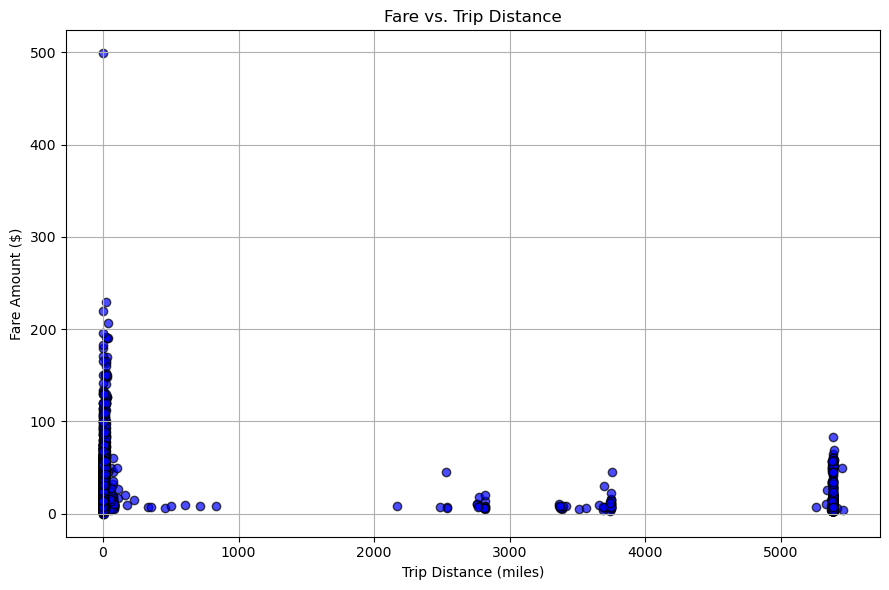

In [450]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data['trip_distance'], data['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Fare vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

trip distance q1: 0.7966164741480826
trip distance q2 (median): 1.3577439460007765
trip distance q3: 2.461080608676155


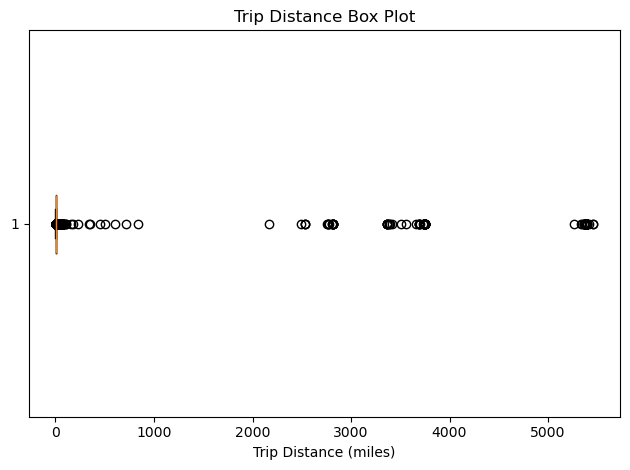

In [456]:
# trip distance box plot

import matplotlib.pyplot as plt
import numpy as np

trip_dis_q1 = np.percentile(data['trip_distance'], 25)
trip_dis_q2 = np.percentile(data['trip_distance'], 50)
trip_dis_q3 = np.percentile(data['trip_distance'], 75)

print(f"trip distance q1: {trip_dis_q1}")
print(f"trip distance q2 (median): {trip_dis_q2}")
print(f"trip distance q3: {trip_dis_q3}")

plt.boxplot(data['trip_distance'], vert=False)
plt.xlabel('Trip Distance (miles)')

plt.title('Trip Distance Box Plot')

plt.tight_layout()
plt.show()

fare amount q1: 6.0
fare amount q2 (median): 8.5
fare amount q3: 12.5


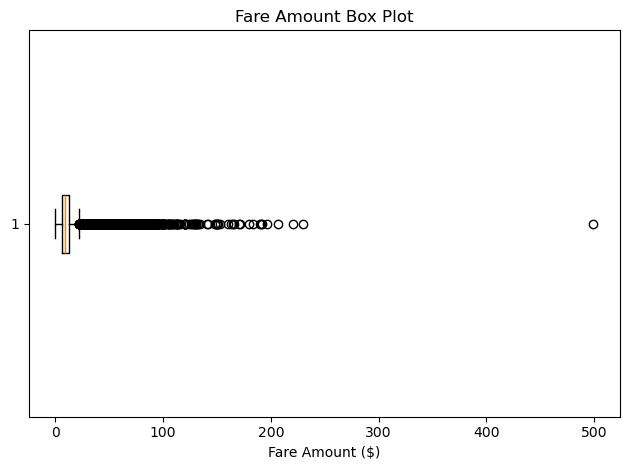

In [455]:
# fare amount box plot

import matplotlib.pyplot as plt
import numpy as np

fare_q1 = np.percentile(data['fare_amount'], 25)
fare_q2 = np.percentile(data['fare_amount'], 50)
fare_q3 = np.percentile(data['fare_amount'], 75)

print(f"fare amount q1: {fare_q1}")
print(f"fare amount q2 (median): {fare_q2}")
print(f"fare amount q3: {fare_q3}")

plt.boxplot(data['fare_amount'], vert=False)

plt.title('Fare Amount Box Plot')
plt.xlabel('Fare Amount ($)')

plt.tight_layout()
plt.show()

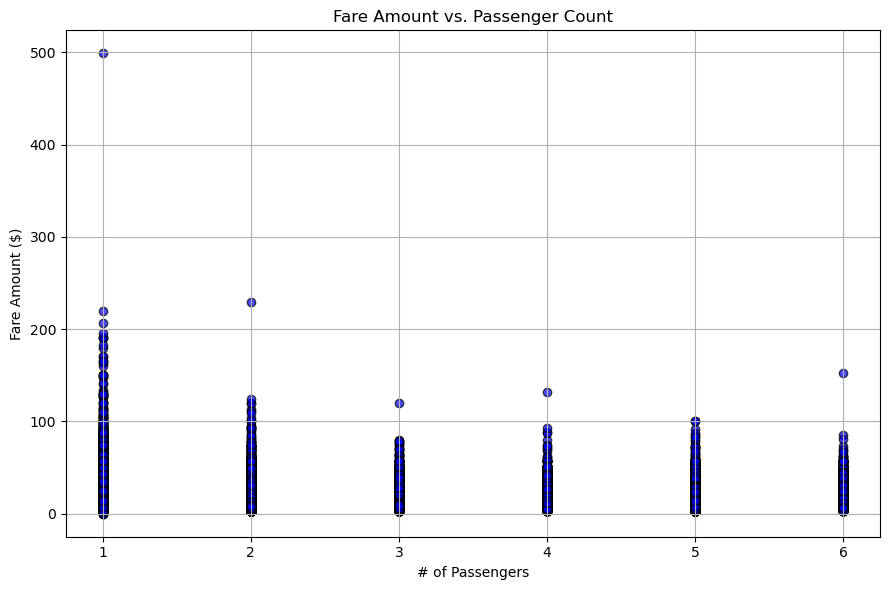

In [454]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data['passenger_count'], data['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Fare Amount vs. Passenger Count')
plt.xlabel('# of Passengers')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

### Reducing Outliers
#### Note: we are getting rid of outliers that look more like invalid data

In [457]:
data_reduced = data[data['trip_distance'] < 200]
data_reduced = data_reduced[data_reduced['trip_distance'] > 0]
data_reduced = data_reduced[data_reduced['fare_amount'] < 300]
data_reduced = data_reduced[data_reduced['fare_amount'] > 0]

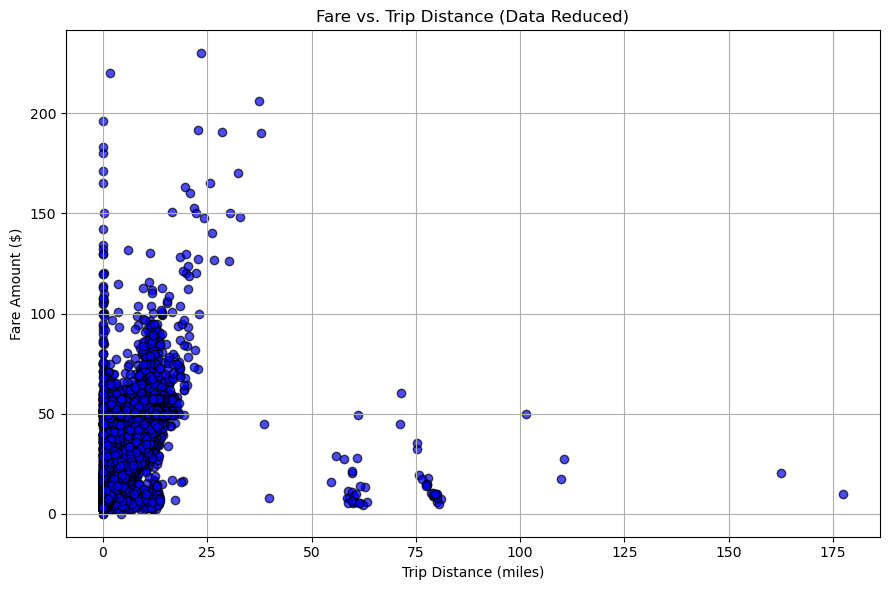

In [458]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data_reduced['trip_distance'], data_reduced['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Fare vs. Trip Distance (Data Reduced)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

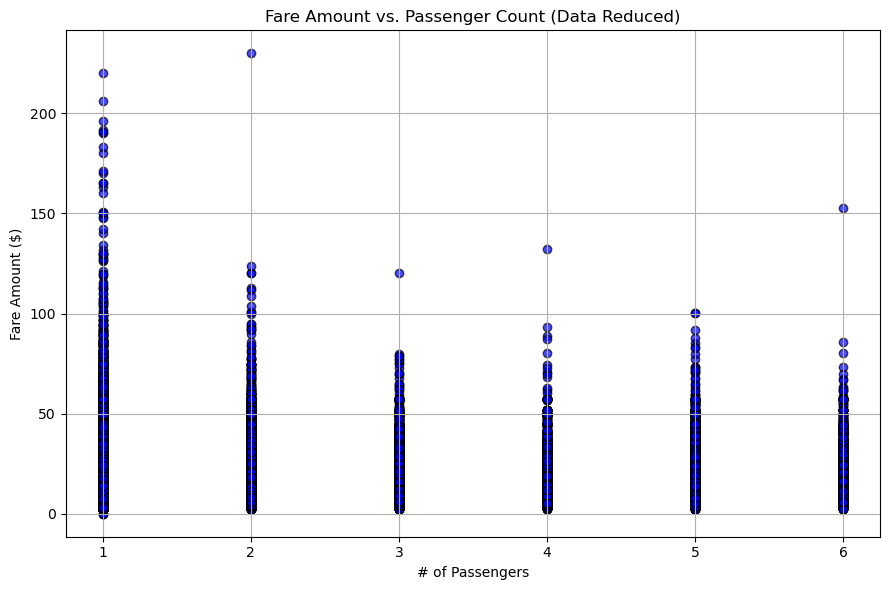

In [ ]:
import matplotlib.pyplot as plt

# fare v. passenger count scatter plot (data reduced)
plt.figure(figsize=(9, 6))
plt.scatter(data_reduced['passenger_count'], data_reduced['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Fare Amount vs. Passenger Count (Data Reduced)')
plt.xlabel('# of Passengers')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

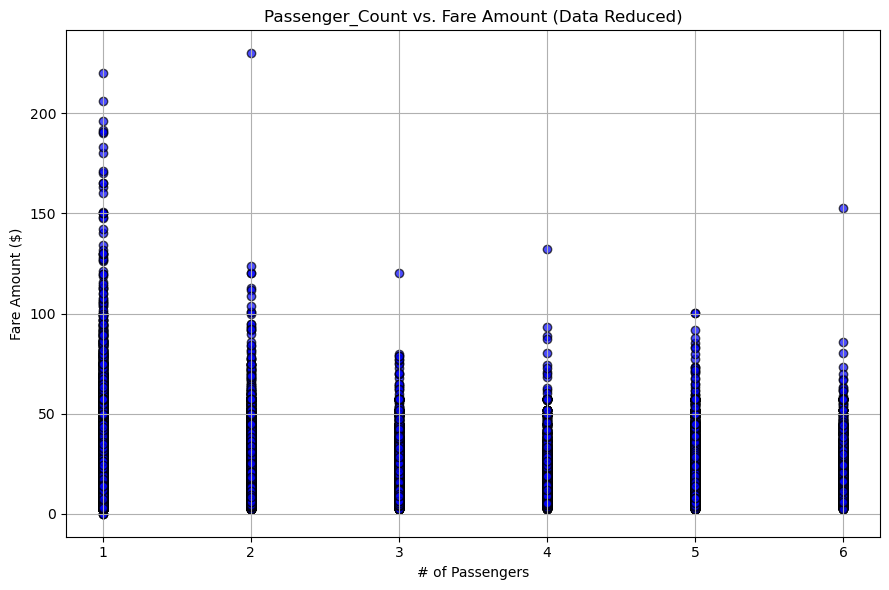

In [460]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data_reduced['passenger_count'], data_reduced['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Passenger_Count vs. Fare Amount (Data Reduced)')
plt.xlabel('# of Passengers')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

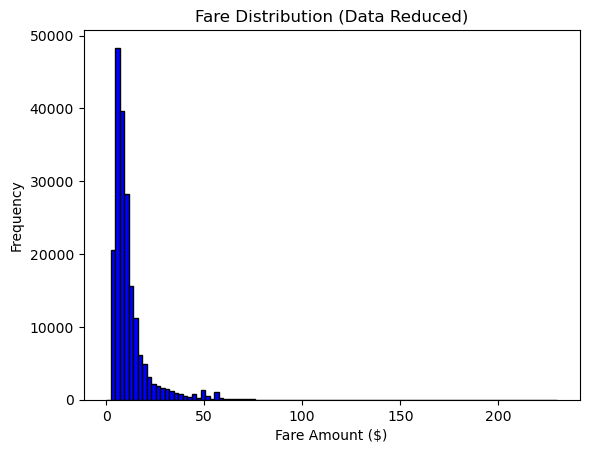

In [592]:
# fare distribution (data reduced)

import matplotlib.pyplot as plt

plt.hist(data_reduced['fare_amount'], bins=100, color='blue', edgecolor='black')
plt.title('Fare Distribution (Data Reduced)')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

In [461]:
data_reduced

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6,1.045980
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56,1.527093
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,3.129495
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21,1.032534
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0,2.780947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0,0.069725
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0,1.165115
199997,30.9,-73.986017,40.756487,-73.858957,40.692588,2,2009,6,29,0,42,0,7.984907
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25,2.199502


In [462]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193222 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        193222 non-null  float64
 1   pickup_longitude   193222 non-null  float64
 2   pickup_latitude    193222 non-null  float64
 3   dropoff_longitude  193222 non-null  float64
 4   dropoff_latitude   193222 non-null  float64
 5   passenger_count    193222 non-null  int64  
 6   pickup_year        193222 non-null  int32  
 7   pickup_month       193222 non-null  int32  
 8   pickup_day         193222 non-null  int32  
 9   pickup_hour        193222 non-null  int32  
 10  pickup_minute      193222 non-null  int32  
 11  pickup_second      193222 non-null  int32  
 12  trip_distance      193222 non-null  float64
dtypes: float64(6), int32(6), int64(1)
memory usage: 16.2 MB


### Removing Outliers
#### Note: we are removing outliers that are outliers based on the IQR for the fare amounts and trip distances

In [463]:
# removing outliers from trip distance

trip_iqr = trip_dis_q3 - trip_dis_q1

lower_bound = trip_dis_q1 - 1.5 * trip_iqr
upper_bound = trip_dis_q3 + 1.5 * trip_iqr

print(f"lower bound: {lower_bound}")
print(f"upper bound: {upper_bound}")

data_no_outliers = data[data['trip_distance'] < upper_bound]
data_no_outliers = data_no_outliers[data_no_outliers['trip_distance'] > lower_bound]

data_no_outliers

lower bound: -1.7000797276440263
upper bound: 4.957776810468264


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6,1.045980
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56,1.527093
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,3.129495
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21,1.032534
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0,2.780947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199994,12.0,-73.983070,40.760770,-73.972972,40.754177,1,2014,1,31,14,42,0,0.697732
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0,0.069725
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0,1.165115
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25,2.199502


trip distance q1: 0.7966164741480826
trip distance q2 (median): 1.3577439460007765
trip distance q3: 2.461080608676155


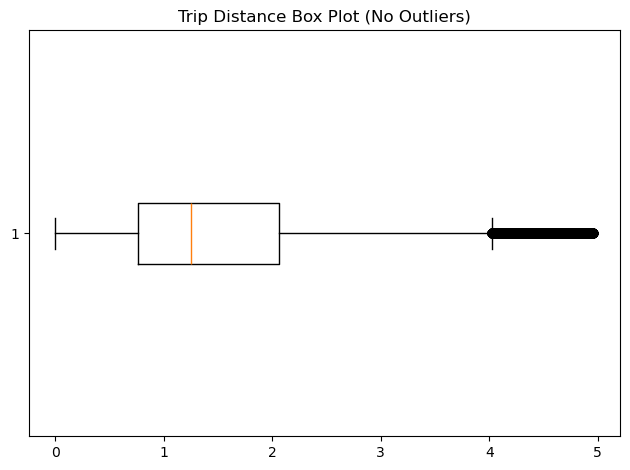

In [464]:
print(f"trip distance q1: {trip_dis_q1}")
print(f"trip distance q2 (median): {trip_dis_q2}")
print(f"trip distance q3: {trip_dis_q3}")

plt.boxplot(data_no_outliers['trip_distance'], vert=False)

plt.title('Trip Distance Box Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [470]:
fare_iqr = fare_q3 - fare_q1

fare_lower_bound = fare_q1 - 1.5 * fare_iqr
fare_upper_bound = fare_q3 + 1.5 * fare_iqr

print(f"lower bound: {fare_lower_bound}")
print(f"upper bound: {fare_upper_bound}")

data_no_outliers = data_no_outliers[data_no_outliers['fare_amount'] < fare_upper_bound]
data_no_outliers = data_no_outliers[data_no_outliers['fare_amount'] > fare_lower_bound]

# data_no_outliers.info()

lower bound: -2.249999999999999
upper bound: 18.95


fare amount q1: 5.7
fare amount q2 (median): 8.0
fare amount q3: 11.0


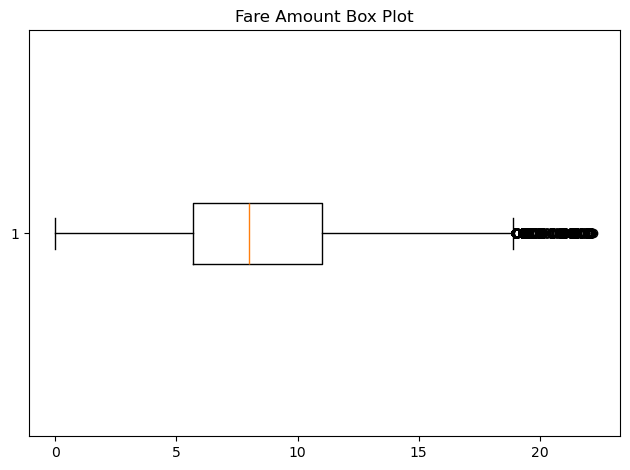

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fare_q1 = np.percentile(data_no_outliers['fare_amount'], 25)
fare_q2 = np.percentile(data_no_outliers['fare_amount'], 50)
fare_q3 = np.percentile(data_no_outliers['fare_amount'], 75)

print(f"fare amount q1: {fare_q1}")
print(f"fare amount q2 (median): {fare_q2}")
print(f"fare amount q3: {fare_q3}")

plt.boxplot(data_no_outliers['fare_amount'], vert=False)

plt.title('Fare Amount Box Plot (No Outliers)')

plt.tight_layout()
plt.show()

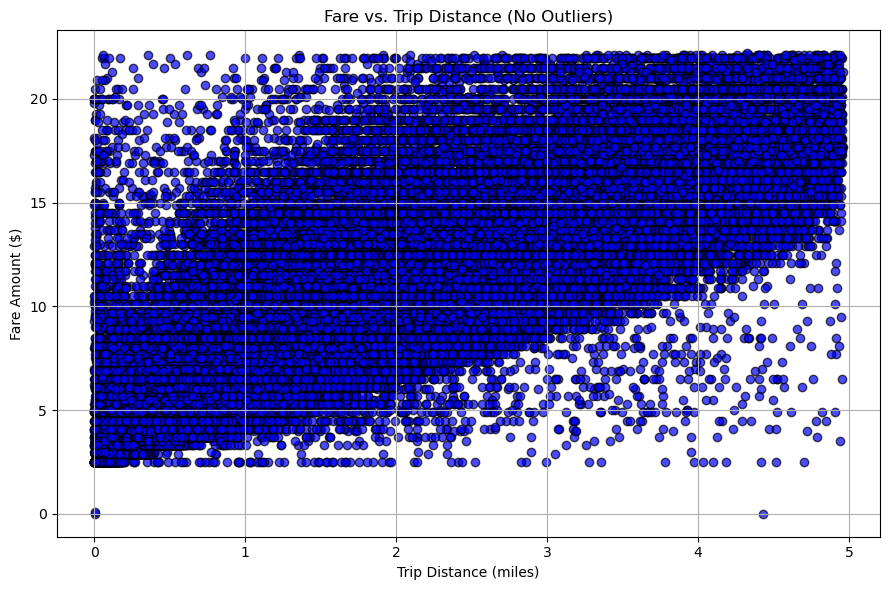

In [467]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data_no_outliers['trip_distance'], data_no_outliers['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Fare vs. Trip Distance (No Outliers)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

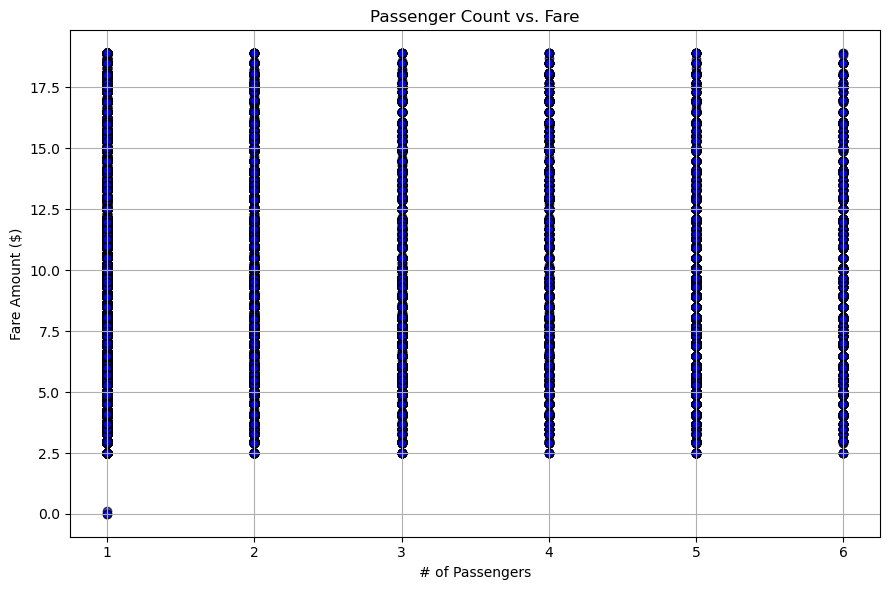

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.scatter(data_no_outliers['passenger_count'], data_no_outliers['fare_amount'], alpha=0.7, c='blue', edgecolors='black')

plt.title('Fare vs. Passenger Count (No Outliers)')
plt.xlabel('# of Passengers')
plt.ylabel('Fare Amount ($)')

plt.grid(True)
plt.tight_layout()
plt.show()

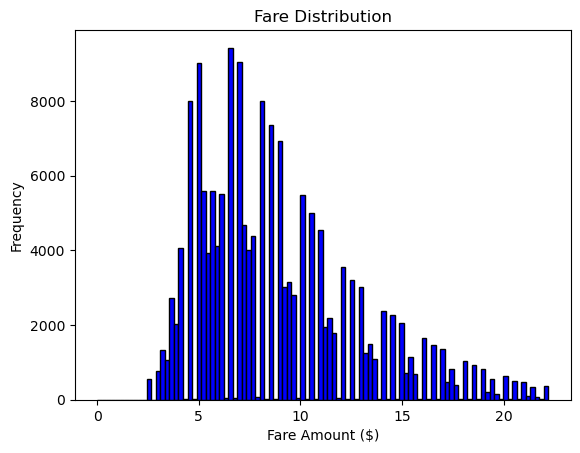

In [ ]:
import matplotlib.pyplot as plt

plt.hist(data_no_outliers['fare_amount'], bins=100, color='blue', edgecolor='black')
plt.title('Fare Distribution (No Outliers)')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

In [472]:
data_no_outliers

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,trip_distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,6,1.045980
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,56,1.527093
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,3.129495
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,21,1.032534
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,0,2.780947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199994,12.0,-73.983070,40.760770,-73.972972,40.754177,1,2014,1,31,14,42,0,0.697732
199995,3.0,-73.987042,40.739367,-73.986525,40.740297,1,2012,10,28,10,49,0,0.069725
199996,7.5,-73.984722,40.736837,-74.006672,40.739620,1,2014,3,14,1,9,0,1.165115
199998,14.5,-73.997124,40.725452,-73.983215,40.695415,1,2015,5,20,14,56,25,2.199502


In [473]:
data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169784 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        169784 non-null  float64
 1   pickup_longitude   169784 non-null  float64
 2   pickup_latitude    169784 non-null  float64
 3   dropoff_longitude  169784 non-null  float64
 4   dropoff_latitude   169784 non-null  float64
 5   passenger_count    169784 non-null  int64  
 6   pickup_year        169784 non-null  int32  
 7   pickup_month       169784 non-null  int32  
 8   pickup_day         169784 non-null  int32  
 9   pickup_hour        169784 non-null  int32  
 10  pickup_minute      169784 non-null  int32  
 11  pickup_second      169784 non-null  int32  
 12  trip_distance      169784 non-null  float64
dtypes: float64(6), int32(6), int64(1)
memory usage: 14.2 MB


---

In [510]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193222 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        193222 non-null  float64
 1   pickup_longitude   193222 non-null  float64
 2   pickup_latitude    193222 non-null  float64
 3   dropoff_longitude  193222 non-null  float64
 4   dropoff_latitude   193222 non-null  float64
 5   passenger_count    193222 non-null  int64  
 6   pickup_year        193222 non-null  int32  
 7   pickup_month       193222 non-null  int32  
 8   pickup_day         193222 non-null  int32  
 9   pickup_hour        193222 non-null  int32  
 10  pickup_minute      193222 non-null  int32  
 11  pickup_second      193222 non-null  int32  
 12  trip_distance      193222 non-null  float64
dtypes: float64(6), int32(6), int64(1)
memory usage: 16.2 MB


In [511]:
data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169784 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        169784 non-null  float64
 1   pickup_longitude   169784 non-null  float64
 2   pickup_latitude    169784 non-null  float64
 3   dropoff_longitude  169784 non-null  float64
 4   dropoff_latitude   169784 non-null  float64
 5   passenger_count    169784 non-null  int64  
 6   pickup_year        169784 non-null  int32  
 7   pickup_month       169784 non-null  int32  
 8   pickup_day         169784 non-null  int32  
 9   pickup_hour        169784 non-null  int32  
 10  pickup_minute      169784 non-null  int32  
 11  pickup_second      169784 non-null  int32  
 12  trip_distance      169784 non-null  float64
dtypes: float64(6), int32(6), int64(1)
memory usage: 14.2 MB


### Splitting Data

In [ ]:
from sklearn.preprocessing import StandardScaler

X1 = data_reduced.drop('fare_amount', axis=1)
y1 = data_reduced['fare_amount']

X2 = data_no_outliers.drop('fare_amount', axis=1)
y2 = data_no_outliers['fare_amount']

---

## Model Testing

In [534]:
reduced_models_metrics = []
no_outliers_models_metrics = []

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
X1 = data_reduced.drop('fare_amount', axis=1)
y1 = data_reduced['fare_amount']
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X1, y1, test_size=0.3, random_state=1)

X2 = data_no_outliers.drop('fare_amount', axis=1)
y2 = data_no_outliers['fare_amount']
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X2, y2, test_size=0.3, random_state=1)

size of reduced dataset: 135255
size of no outliers dataset: 118848


### Linear Regression

In [493]:
# training linear regression models
from sklearn.linear_model import LinearRegression

lin_reg_reduced_model = LinearRegression()
lin_reg_reduced_model.fit(X_train_reduced, y_train_reduced)

lin_reg_no_outliers_model = LinearRegression()
lin_reg_no_outliers_model.fit(X_train_no_outliers, y_train_no_outliers)

LinearRegression()

In [494]:
lin_reduced_y_pred = lin_reg_reduced_model.predict(X_test_reduced)
lin_no_outliers_y_pred = lin_reg_no_outliers_model.predict(X_test_no_outliers)

In [535]:
from sklearn.metrics import mean_squared_error

linear_reduced_mse = mean_squared_error(y_test_reduced, lin_reduced_y_pred)
linear_reduced_rmse = np.sqrt(linear_reduced_mse)
linear_reduced_mae = mean_absolute_error(y_test_reduced, lin_reduced_y_pred)
linear_reduced_r2 = lin_reg_reduced_model.score(X_test_reduced, y_test_reduced)

linear_no_outliers_mse = mean_squared_error(y_test_no_outliers, lin_no_outliers_y_pred)
linear_no_outliers_rmse = np.sqrt(linear_no_outliers_mse)
linear_no_outliers_mae = mean_absolute_error(y_test_no_outliers, lin_no_outliers_y_pred)
linear_no_outliers_r2 = lin_reg_no_outliers_model.score(X_test_no_outliers, y_test_no_outliers)


reduced_models_metrics.append({
    "model": "linear regression",
    "mse": linear_reduced_mse,
    "rmse": linear_reduced_rmse,
    "mae": linear_reduced_mae,
    "r2": linear_reduced_r2
})

no_outliers_models_metrics.append({
    "model": "linear regression",
    "mse": linear_no_outliers_mse,
    "rmse": linear_no_outliers_rmse,
    "mae": linear_no_outliers_mae,
    "r2": linear_no_outliers_r2
})

In [536]:
print("linear regression (reduced)")

print(f"mse: {linear_reduced_mse}")
print(f"rmse: {linear_reduced_rmse}")
print(f"mae: {linear_reduced_mae}")
print(f"R2: {linear_reduced_r2} ")
print("\n")

print("linear regression (no outliers)")

print(f"mse: {linear_no_outliers_mse}")
print(f"rmse: {linear_no_outliers_rmse}")
print(f"mae: {linear_no_outliers_mae}")
print(f"R2: {linear_no_outliers_r2} ")

linear regression (reduced)
mse: 33.13984340191399
rmse: 5.756721584540458
mae: 2.749937951695904
R2: 0.6423157176191536 


linear regression (no outliers)
mse: 4.025616815724264
rmse: 2.006393983175853
mae: 1.4631203967500184
R2: 0.6889780803562462 


### Ridge Regression w/ Cross Validation

In [530]:
from sklearn.linear_model import RidgeCV

k = 5

alphas = np.logspace(-3, 3, 10)

reduced_ridge_cv = RidgeCV(alphas=alphas, cv=k)
reduced_ridge_cv.fit(X_train_reduced, y_train_reduced)

no_outliers_ridge_cv = RidgeCV(alphas=alphas, cv=k)
no_outliers_ridge_cv.fit(X_train_no_outliers, y_train_no_outliers)

RidgeCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
        cv=5)

In [537]:
ridge_y_pred_reduced = reduced_ridge_cv.predict(X_test_reduced)
ridge_y_pred_no_outliers = no_outliers_ridge_cv.predict(X_test_no_outliers)

In [538]:
ridge_reduced_mse = mean_squared_error(y_test_reduced, ridge_y_pred_reduced)
ridge_reduced_rmse = np.sqrt(ridge_reduced_mse)
ridge_reduced_mae = mean_absolute_error(y_test_reduced, ridge_y_pred_reduced)
ridge_reduced_r2 = ridge_cv.score(X_test_reduced, y_test_reduced)

ridge_no_outliers_mse = mean_squared_error(y_test_no_outliers, ridge_y_pred_no_outliers)
ridge_no_outliers_rmse = np.sqrt(ridge_no_outliers_mse)
ridge_no_outliers_mae = mean_absolute_error(y_test_no_outliers, ridge_y_pred_no_outliers)
ridge_no_outliers_r2 = ridge_cv.score(X_test_no_outliers, y_test_no_outliers)

reduced_models_metrics.append({
    "model": "ridge regression",
    "mse": ridge_reduced_mse,
    "rmse": ridge_reduced_rmse,
    "mae": ridge_reduced_mae,
    "r2": ridge_reduced_r2
})

no_outliers_models_metrics.append({
    "model": "ridge regression",
    "mse": ridge_no_outliers_mse,
    "rmse": ridge_no_outliers_rmse,
    "mae": ridge_no_outliers_mae,
    "r2": ridge_no_outliers_r2
})

In [539]:
print("ridge regression (reduced)")

print(f"mse: {ridge_reduced_mse}")
print(f"rmse: {ridge_reduced_rmse}")
print(f"mae: {ridge_reduced_mae}")
print(f"R2: {ridge_reduced_r2} ")
print("\n")

print("ridge regression (no outliers)")

print(f"mse: {ridge_no_outliers_mse}")
print(f"rmse: {ridge_no_outliers_rmse}")
print(f"mae: {ridge_no_outliers_mae}")
print(f"R2: {ridge_no_outliers_r2} ")

ridge regression (reduced)
mse: 32.94482876933666
rmse: 5.739758598524563
mae: 2.739332212594474
R2: 0.6434804916952269 


ridge regression (no outliers)
mse: 4.025615665191518
rmse: 2.006393696459276
mae: 1.4631167785035113
R2: 0.6888180421782195 


### Polynomial Regression

In [540]:
from sklearn.model_selection import cross_val_score

print("cross validation for polynomial regression (reduced)")
for d in range(2, 4):
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly_reduced = poly.fit_transform(X_train_reduced)

    model = LinearRegression()
    scores = cross_val_score(model, X_poly_reduced, y_train_reduced, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    print(f"deg {d}, mean mse: {mean_score:.2f}")

print("\n")

print("cross validation for polynomial regression (no outliers)")
for d in range(2, 4):
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly_no_outliers = poly.fit_transform(X_train_no_outliers)
    
    model = LinearRegression()
    scores = cross_val_score(model, X_poly_no_outliers, y_train_no_outliers, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    print(f"deg {d}, mean mse: {mean_score:.2f}")


cross validation for polynomial regression (reduced)
deg 2, mean mse: 26.15
deg 3, mean mse: 45719.65


cross validation for polynomial regression (no outliers)
deg 2, mean mse: 3.71
deg 3, mean mse: 54274.47


In [541]:
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly2_train_reduced = poly2.fit_transform(X_train_reduced)
X_poly2_train_no_outliers = poly2.fit_transform(X_train_no_outliers)

reduced_poly2_model = LinearRegression()
reduced_poly2_model.fit(X_poly2_train_reduced, y_train_reduced)

no_outlier_poly2_model = LinearRegression()
no_outlier_poly2_model.fit(X_poly2_train_no_outliers, y_train_no_outliers)

LinearRegression()

In [542]:
poly2_pred_reduced = reduced_poly2_model.predict(poly2.transform(X_test_reduced))
poly2_pred_no_outliers = no_outlier_poly2_model.predict(poly2.transform(X_test_no_outliers))

In [543]:
poly2_reduced_mse = mean_squared_error(y_test_reduced, poly2_pred_reduced)
poly2_reduced_rmse = np.sqrt(poly2_reduced_mse)
poly2_reduced_mae = mean_absolute_error(y_test_reduced, poly2_pred_reduced)
poly2_reduced_r2 = reduced_poly2_model.score(poly2.transform(X_test_reduced), y_test_reduced)

poly2_no_outliers_mse = mean_squared_error(y_test_no_outliers, poly2_pred_no_outliers)
poly2_no_outliers_rmse = np.sqrt(poly2_no_outliers_mse)
poly2_no_outliers_mae = mean_absolute_error(y_test_no_outliers, poly2_pred_no_outliers)
poly2_no_outliers_r2 = no_outlier_poly2_model.score(poly2.transform(X_test_no_outliers), y_test_no_outliers)

reduced_models_metrics.append({
    "model": "polynomial regression",
    "mse": poly2_reduced_mse,
    "rmse": poly2_reduced_rmse,
    "mae": poly2_reduced_mae,
    "r2": poly2_reduced_r2
})

no_outliers_models_metrics.append({
    "model": "polynomial regression",
    "mse": poly2_no_outliers_mse,
    "rmse": poly2_no_outliers_rmse,
    "mae": poly2_no_outliers_mae,
    "r2": poly2_no_outliers_r2
})

In [544]:
print("polynomial regression (reduced)")

print(f"mse: {poly2_reduced_mse}")  
print(f"rmse: {poly2_reduced_rmse}")
print(f"mae: {poly2_reduced_mae}")
print(f"R2: {poly2_reduced_r2} ")
print("\n")

print("polynomial regression (no outliers)")

print(f"mse: {poly2_no_outliers_mse}")
print(f"rmse: {poly2_no_outliers_rmse}")
print(f"mae: {poly2_no_outliers_mae}")
print(f"R2: {poly2_no_outliers_r2} ")

polynomial regression (reduced)
mse: 20.109169250979228
rmse: 4.484324837807719
mae: 2.1427019492907684
R2: 0.782958124286246 


polynomial regression (no outliers)
mse: 3.6847023959953775
rmse: 1.9195578647166065
mae: 1.3629674748854912
R2: 0.7153173625363456 


### Decision Tree Regression

In [545]:
from sklearn.tree import DecisionTreeRegressor

dt_reduced = DecisionTreeRegressor(random_state=42)
dt_reduced.fit(X_train_reduced, y_train_reduced)

dt_no_outliers = DecisionTreeRegressor(random_state=42)
dt_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

dt_reduced.fit(X_train_reduced, y_train_reduced)
dt_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

DecisionTreeRegressor(random_state=42)

In [546]:
dt_y_pred_reduced = dt_reduced.predict(X_test_reduced)
dt_y_pred_no_outliers = dt_no_outliers.predict(X_test_no_outliers)

In [547]:
dt_mse_reduced = mean_squared_error(y_test_reduced, dt_y_pred_reduced)
dt_rmse_reduced = np.sqrt(dt_mse_reduced)
dt_mae_reduced = mean_absolute_error(y_test_reduced, dt_y_pred_reduced)
dt_r2_reduced = dt_reduced.score(X_test_reduced, y_test_reduced)

dt_mse_no_outliers = mean_squared_error(y_test_no_outliers, dt_y_pred_no_outliers)
dt_rmse_no_outliers = np.sqrt(dt_mse_no_outliers)
dt_mae_no_outliers = mean_absolute_error(y_test_no_outliers, dt_y_pred_no_outliers)
dt_r2_no_outliers = dt_no_outliers.score(X_test_no_outliers, y_test_no_outliers)

reduced_models_metrics.append({
    "model": "decision tree regression",
    "mse": dt_mse_reduced,
    "rmse": dt_rmse_reduced,
    "mae": dt_mae_reduced,
    "r2": dt_r2_reduced
})

no_outliers_models_metrics.append({
    "model": "decision tree regression",
    "mse": dt_mse_no_outliers,
    "rmse": dt_rmse_no_outliers,
    "mae": dt_mae_no_outliers,
    "r2": dt_r2_no_outliers
})

In [548]:
print("decision tree regression (reduced)")

print(f"mse: {dt_mse_reduced}")
print(f"rmse: {dt_rmse_reduced}")
print(f"mae: {dt_mae_reduced}")
print(f"R2: {dt_r2_reduced}")

print("\n")

print("decision tree regression (no outliers)")

print(f"mse: {dt_mse_no_outliers}")
print(f"rmse: {dt_rmse_no_outliers}")
print(f"mae: {dt_mae_no_outliers}")
print(f"R2: {dt_r2_no_outliers}")

decision tree regression (reduced)
mse: 26.94028482239895
rmse: 5.190403146423113
mae: 2.552803664153743
R2: 0.7092286669260832


decision tree regression (no outliers)
mse: 6.5521701016962455
rmse: 2.5597207077523607
mae: 1.7981072326056227
R2: 0.493774838454083


### Random Forest Regression

In [549]:
from sklearn.ensemble import RandomForestRegressor

rf_reduced = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_reduced.fit(X_train_reduced, y_train_reduced)

rf_no_outliers = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

RandomForestRegressor(random_state=42)

In [550]:
rf_y_pred_reduced = rf_reduced.predict(X_test_reduced)
rf_y_pred_no_outliers = rf_no_outliers.predict(X_test_no_outliers)

In [552]:
rf_reduced_mse = mean_squared_error(y_test_reduced, rf_y_pred_reduced)
rf_reduced_rmse = np.sqrt(rf_reduced_mse)
rf_reduced_mae = mean_absolute_error(y_test_reduced, rf_y_pred_reduced)
rf_reduced_r2 = rf_reduced.score(X_test_reduced, y_test_reduced)

rf_no_outliers_mse = mean_squared_error(y_test_no_outliers, rf_y_pred_no_outliers)
rf_no_outliers_rmse = np.sqrt(rf_no_outliers_mse)
rf_no_outliers_mae = mean_absolute_error(y_test_no_outliers, rf_y_pred_no_outliers)
rf_no_outliers_r2 = rf_no_outliers.score(X_test_no_outliers, y_test_no_outliers)

reduced_models_metrics.append({
    "model": "random forest regression",
    "mse": rf_reduced_mse,
    "rmse": rf_reduced_rmse,
    "mae": rf_reduced_mae,
    "r2": rf_reduced_r2
})

no_outliers_models_metrics.append({
    "model": "random forest regression",
    "mse": rf_no_outliers_mse,
    "rmse": rf_no_outliers_rmse,
    "mae": rf_no_outliers_mae,
    "r2": rf_no_outliers_r2
})

In [553]:
print("random forest regression (reduced)")

print(f"mse: {rf_reduced_mse}")
print(f"rmse: {rf_reduced_rmse}")
print(f"mae: {rf_reduced_mae}")
print(f"R2: {rf_reduced_r2}")

print("\n")

print("random forest regression (no outliers)")

print(f"mse: {rf_no_outliers_mse}")
print(f"rmse: {rf_no_outliers_rmse}")
print(f"mae: {rf_no_outliers_mae}")
print(f"R2: {rf_no_outliers_r2}")

random forest regression (reduced)
mse: 13.581407660822018
rmse: 3.6852961428929993
mae: 1.8170923094174272
R2: 0.8534134276385178


random forest regression (no outliers)
mse: 3.1898692890376155
rmse: 1.7860205175298562
mae: 1.2737792916601225
R2: 0.7535485081903804


### Extra Tree Regression

In [555]:
from sklearn.ensemble import ExtraTreesRegressor

n = {25, 50, 100, 200}
best_n = 0
best_score = 0

print("extra trees regression training (reduced)")

for i in n:
    et_reduced = ExtraTreesRegressor(n_estimators=i, max_depth=None, random_state=42)
    et_reduced.fit(X_train_reduced, y_train_reduced)

    et_y_pred_reduced = et_reduced.predict(X_test_reduced)

    if et_reduced.score(X_test_reduced, y_test_reduced) > best_score or best_n == 0:
        best_n = i
        best_score = et_reduced.score(X_test_reduced, y_test_reduced)
        et_reduced_model = et_reduced

print(f"best n: {best_n}")

extra trees regression training (reduced)
best n: 200


In [556]:
from sklearn.ensemble import ExtraTreesRegressor

n = {25, 50, 100, 200}
best_n = 0
best_score = 0


print("extra trees regression training (no outliers)")

for i in n:
    et_no_outliers = ExtraTreesRegressor(n_estimators=i, max_depth=None, random_state=42)
    et_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

    et_y_pred_no_outliers = et_no_outliers.predict(X_test_no_outliers)

    if et_no_outliers.score(X_test_no_outliers, y_test_no_outliers) > best_score or best_n == 0:
        best_n = i
        best_score = et_no_outliers.score(X_test_no_outliers, y_test_no_outliers)
        et_no_outliers_model = et_no_outliers

print(f"best n: {best_n}")

extra trees regression training (no outliers)
best n: 200


In [558]:
et_y_pred_reduced = et_reduced_model.predict(X_test_reduced)
et_y_pred_no_outliers = et_no_outliers_model.predict(X_test_no_outliers)

In [560]:
et_reduced_mse = mean_squared_error(y_test_reduced, et_y_pred_reduced)
et_reduced_rmse = np.sqrt(et_reduced_mse)
et_reduced_mae = mean_absolute_error(y_test_reduced, et_y_pred_reduced)
et_reduced_r2 = et_reduced_model.score(X_test_reduced, y_test_reduced)

et_no_outliers_mse = mean_squared_error(y_test_no_outliers, et_y_pred_no_outliers)
et_no_outliers_rmse = np.sqrt(et_no_outliers_mse)
et_no_outliers_mae = mean_absolute_error(y_test_no_outliers, et_y_pred_no_outliers)
et_no_outliers_r2 = et_no_outliers_model.score(X_test_no_outliers, y_test_no_outliers)

reduced_models_metrics.append({
    "model": "extra trees regression",
    "mse": et_reduced_mse,
    "rmse": et_reduced_rmse,
    "mae": et_reduced_mae,
    "r2": et_reduced_r2
})

no_outliers_models_metrics.append({
    "model": "extra trees regression",
    "mse": et_no_outliers_mse,
    "rmse": et_no_outliers_rmse,
    "mae": et_no_outliers_mae,
    "r2": et_no_outliers_r2
})

In [561]:
print("extra trees regression (reduced)")

print(f"mse: {et_reduced_mse}")
print(f"rmse: {et_reduced_rmse}")
print(f"mae: {et_reduced_mae}")
print(f"R2: {et_reduced_r2}")

print("\n")

print("extra trees regression (no outliers)")

print(f"mse: {et_no_outliers_mse}")
print(f"rmse: {et_no_outliers_rmse}")
print(f"mae: {et_no_outliers_mae}")
print(f"R2: {et_no_outliers_r2}")

extra trees regression (reduced)
mse: 13.862405671454967
rmse: 3.723225170662522
mae: 1.8786877568271607
R2: 0.8503805656371878


extra trees regression (no outliers)
mse: 3.3674496157149654
rmse: 1.8350612021714603
mae: 1.3241608381105703
R2: 0.7398285302037977


### Gradient Boosting Machines (GBM)

In [562]:
import xgboost as xgb

xgb_model_reduced = xgb.XGBRegressor(
    n_estimators=100,       
    learning_rate=0.1,      
    max_depth=6,         
    subsample=0.8,          
    colsample_bytree=0.8     
)

xgb_model_no_outliers = xgb.XGBRegressor(
    n_estimators=100,       
    learning_rate=0.1,      
    max_depth=6,         
    subsample=0.8,          
    colsample_bytree=0.8     
)

xgb_model_reduced.fit(X_train_reduced, y_train_reduced)
xgb_model_no_outliers.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [565]:
xgb_y_pred_reduced = xgb_model_reduced.predict(X_test_reduced)
xgb_y_pred_no_outliers = xgb_model_no_outliers.predict(X_test_no_outliers)

In [566]:
xgb_mse_reduced = mean_squared_error(y_test_reduced, xgb_y_pred_reduced)
xgb_rmse_reduced = np.sqrt(xgb_mse_reduced)
xgb_mae_reduced = mean_absolute_error(y_test_reduced, xgb_y_pred_reduced)
xgb_r2_reduced = xgb_model_reduced.score(X_test_reduced, y_test_reduced)

xgb_mse_no_outliers = mean_squared_error(y_test_no_outliers, xgb_y_pred_no_outliers)
xgb_rmse_no_outliers = np.sqrt(xgb_mse_no_outliers)
xgb_mae_no_outliers = mean_absolute_error(y_test_no_outliers, xgb_y_pred_no_outliers)
xgb_r2_no_outliers = xgb_model_no_outliers.score(X_test_no_outliers, y_test_no_outliers)

reduced_models_metrics.append({
    "model": "lightgbm regression",
    "mse": xgb_mse_reduced,
    "rmse": xgb_rmse_reduced,
    "mae": xgb_mae_reduced,
    "r2": xgb_r2_reduced
})

no_outliers_models_metrics.append({
    "model": "lightgbm regression",
    "mse": xgb_mse_no_outliers,
    "rmse": xgb_rmse_no_outliers,
    "mae": xgb_mae_no_outliers,
    "r2": xgb_r2_no_outliers
})

In [567]:
print("lightgbm regression (reduced)")

print(f"mse: {xgb_mse_reduced}")
print(f"rmse: {xgb_rmse_reduced}")
print(f"mae: {xgb_mae_reduced}")
print(f"R2: {xgb_r2_reduced}")

print("\n")

print("lightgbm regression (no outliers)")

print(f"mse: {xgb_mse_no_outliers}")
print(f"rmse: {xgb_rmse_no_outliers}")
print(f"mae: {xgb_mae_no_outliers}")
print(f"R2: {xgb_r2_no_outliers}")

lightgbm regression (reduced)
mse: 13.713635804211046
rmse: 3.7031926501616206
mae: 1.7986803237811986
R2: 0.8519862655362394


lightgbm regression (no outliers)
mse: 2.9133040438001823
rmse: 1.7068403685758613
mae: 1.206356003838655
R2: 0.7749161289595758


---

### Models & Metrics (Reduced)

In [571]:
print("models metrics (reduced)\n")
for model in reduced_models_metrics:
    print(model['model'])

    print(f"mse: {model['mse']}")
    print(f"rmse: {model['rmse']}")
    print(f"mae: {model['mae']}")
    print(f"R2: {model['r2']}")
    print("\n")

models metrics (reduced)

linear regression
mse: 33.13984340191399
rmse: 5.756721584540458
mae: 2.749937951695904
R2: 0.6423157176191536


ridge regression
mse: 32.94482876933666
rmse: 5.739758598524563
mae: 2.739332212594474
R2: 0.6434804916952269


polynomial regression
mse: 20.109169250979228
rmse: 4.484324837807719
mae: 2.1427019492907684
R2: 0.782958124286246


decision tree regression
mse: 26.94028482239895
rmse: 5.190403146423113
mae: 2.552803664153743
R2: 0.7092286669260832


random forest regression
mse: 13.581407660822018
rmse: 3.6852961428929993
mae: 1.8170923094174272
R2: 0.8534134276385178


extra trees regression
mse: 13.862405671454967
rmse: 3.723225170662522
mae: 1.8786877568271607
R2: 0.8503805656371878


lightgbm regression
mse: 13.713635804211046
rmse: 3.7031926501616206
mae: 1.7986803237811986
R2: 0.8519862655362394




### Comparing MSE

In [579]:
mse_sorted_reduced = sorted(reduced_models_metrics, key=lambda x: x['mse'])

print("mse sorted (reduced)\n")

for model in mse_sorted_reduced:
    print(model['model'])
    print(f"mse: {model['mse']}")
    print("\n")

mse sorted (reduced)

random forest regression
mse: 13.581407660822018


lightgbm regression
mse: 13.713635804211046


extra trees regression
mse: 13.862405671454967


polynomial regression
mse: 20.109169250979228


decision tree regression
mse: 26.94028482239895


ridge regression
mse: 32.94482876933666


linear regression
mse: 33.13984340191399




### Comparing RMSE

In [580]:
rmse_sorted_reduced = sorted(reduced_models_metrics, key=lambda x: x['rmse'])

print("rmse sorted (reduced)\n")

for model in rmse_sorted_reduced:
    print(model['model'])
    print(f"rmse: {model['rmse']}")
    print("\n")

rmse sorted (reduced)

random forest regression
rmse: 3.6852961428929993


lightgbm regression
rmse: 3.7031926501616206


extra trees regression
rmse: 3.723225170662522


polynomial regression
rmse: 4.484324837807719


decision tree regression
rmse: 5.190403146423113


ridge regression
rmse: 5.739758598524563


linear regression
rmse: 5.756721584540458




### Comparing MAE

In [582]:
mae_sorted_reduced = sorted(reduced_models_metrics, key=lambda x: x['mae'])

print("mae sorted (reduced)\n")

for model in mae_sorted_reduced:
    print(model['model'])
    print(f"mae: {model['mae']}")
    print("\n")

mae sorted (reduced)

lightgbm regression
mae: 1.7986803237811986


random forest regression
mae: 1.8170923094174272


extra trees regression
mae: 1.8786877568271607


polynomial regression
mae: 2.1427019492907684


decision tree regression
mae: 2.552803664153743


ridge regression
mae: 2.739332212594474


linear regression
mae: 2.749937951695904




### Comparing R2 Scores

In [584]:
r2_sorted_reduced = sorted(reduced_models_metrics, key=lambda x: x['r2'], reverse=True)

print("r2 sorted (reduced)\n")

for model in r2_sorted_reduced:
    print(model['model'])
    print(f"r2: {model['r2']}")
    print("\n")

r2 sorted (reduced)

random forest regression
r2: 0.8534134276385178


lightgbm regression
r2: 0.8519862655362394


extra trees regression
r2: 0.8503805656371878


polynomial regression
r2: 0.782958124286246


decision tree regression
r2: 0.7092286669260832


ridge regression
r2: 0.6434804916952269


linear regression
r2: 0.6423157176191536




### Best Model (Reduced)

In [585]:
print("best model: " + r2_sorted_reduced[0]['model'])

print(f"mse: {r2_sorted_reduced[0]['mse']}")
print(f"rmse: {r2_sorted_reduced[0]['rmse']}")
print(f"mae: {r2_sorted_reduced[0]['mae']}")
print(f"R2: {r2_sorted_reduced[0]['r2']}")

best model: random forest regression
mse: 13.581407660822018
rmse: 3.6852961428929993
mae: 1.8170923094174272
R2: 0.8534134276385178


---

### Models & Metrics (No Outliers)

In [586]:
print("models metrics (no outliers)\n")
for model in no_outliers_models_metrics:
    print(model['model'])

    print(f"mse: {model['mse']}")
    print(f"rmse: {model['rmse']}")
    print(f"mae: {model['mae']}")
    print(f"R2: {model['r2']}")
    print("\n")

models metrics (no outliers)

linear regression
mse: 4.025616815724264
rmse: 2.006393983175853
mae: 1.4631203967500184
R2: 0.6889780803562462


ridge regression
mse: 4.025615665191518
rmse: 2.006393696459276
mae: 1.4631167785035113
R2: 0.6888180421782195


polynomial regression
mse: 3.6847023959953775
rmse: 1.9195578647166065
mae: 1.3629674748854912
R2: 0.7153173625363456


decision tree regression
mse: 6.5521701016962455
rmse: 2.5597207077523607
mae: 1.7981072326056227
R2: 0.493774838454083


random forest regression
mse: 3.1898692890376155
rmse: 1.7860205175298562
mae: 1.2737792916601225
R2: 0.7535485081903804


extra trees regression
mse: 3.3674496157149654
rmse: 1.8350612021714603
mae: 1.3241608381105703
R2: 0.7398285302037977


lightgbm regression
mse: 2.9133040438001823
rmse: 1.7068403685758613
mae: 1.206356003838655
R2: 0.7749161289595758




### Comparing MSE

In [587]:
mse_sorted_no_outliers = sorted(no_outliers_models_metrics, key=lambda x: x['mse'])

print("mse sorted (no outliers)\n")

for model in mse_sorted_no_outliers:
    print(model['model'])
    print(f"mse: {model['mse']}")
    print("\n")

mse sorted (no outliers)

lightgbm regression
mse: 2.9133040438001823


random forest regression
mse: 3.1898692890376155


extra trees regression
mse: 3.3674496157149654


polynomial regression
mse: 3.6847023959953775


ridge regression
mse: 4.025615665191518


linear regression
mse: 4.025616815724264


decision tree regression
mse: 6.5521701016962455




### Comparing RMSE

In [588]:
rmse_sorted_no_outliers = sorted(no_outliers_models_metrics, key=lambda x: x['rmse'])

print("rmse sorted (no outliers)\n")

for model in rmse_sorted_no_outliers:
    print(model['model'])
    print(f"rmse: {model['rmse']}")
    print("\n")

rmse sorted (no outliers)

lightgbm regression
rmse: 1.7068403685758613


random forest regression
rmse: 1.7860205175298562


extra trees regression
rmse: 1.8350612021714603


polynomial regression
rmse: 1.9195578647166065


ridge regression
rmse: 2.006393696459276


linear regression
rmse: 2.006393983175853


decision tree regression
rmse: 2.5597207077523607




### Comparing MAE

In [589]:
mae_sorted_no_outliers = sorted(no_outliers_models_metrics, key=lambda x: x['mae'])

print("mae sorted (no outliers)\n")

for model in mae_sorted_no_outliers:
    print(model['model'])
    print(f"mae: {model['mae']}")
    print("\n")

mae sorted (no outliers)

lightgbm regression
mae: 1.206356003838655


random forest regression
mae: 1.2737792916601225


extra trees regression
mae: 1.3241608381105703


polynomial regression
mae: 1.3629674748854912


ridge regression
mae: 1.4631167785035113


linear regression
mae: 1.4631203967500184


decision tree regression
mae: 1.7981072326056227




### Comparing R2 Scores

In [590]:
r2_sorted_no_outliers = sorted(no_outliers_models_metrics, key=lambda x: x['r2'], reverse=True)

print("r2 sorted (no outliers)\n")

for model in r2_sorted_no_outliers:
    print(model['model'])
    print(f"r2: {model['r2']}")
    print("\n")

r2 sorted (no outliers)

lightgbm regression
r2: 0.7749161289595758


random forest regression
r2: 0.7535485081903804


extra trees regression
r2: 0.7398285302037977


polynomial regression
r2: 0.7153173625363456


linear regression
r2: 0.6889780803562462


ridge regression
r2: 0.6888180421782195


decision tree regression
r2: 0.493774838454083




### Best Model (No Outliers)

In [591]:
print("best model: " + r2_sorted_no_outliers[0]['model'])

print(f"mse: {r2_sorted_no_outliers[0]['mse']}")
print(f"rmse: {r2_sorted_no_outliers[0]['rmse']}")
print(f"mae: {r2_sorted_no_outliers[0]['mae']}")
print(f"R2: {r2_sorted_no_outliers[0]['r2']}")

best model: lightgbm regression
mse: 2.9133040438001823
rmse: 1.7068403685758613
mae: 1.206356003838655
R2: 0.7749161289595758
